In [1]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

c:\ProgramData\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
c:\ProgramData\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
# fine-tuning을 위한 데이터셋 만들기 
d_path = 'timage'
from datasets import load_dataset
dataset = load_dataset('./timage/')

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

In [3]:
text_label = ['looks like Jean-Michel Basquiat' for i in range(len(dataset['train']['image']))]


In [4]:
dataset['train'] = dataset['train'].add_column('text',text_label)

In [5]:
from diffusers.optimization import get_scheduler
from diffusers.utils import convert_state_dict_to_diffusers
from diffusers.training_utils import cast_training_params
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torchvision import transforms
from peft import LoraConfig
from peft.utils import get_peft_model_state_dict

In [6]:
from tqdm import tqdm

from PIL import Image

device = 'cpu'

pre_trained_model_name = 'CompVis/stable-diffusion-v1-4'

noise_scheduler = PNDMScheduler.from_pretrained(pre_trained_model_name,subfolder='scheduler')

tokenizer = CLIPTokenizer.from_pretrained(pre_trained_model_name,subfolder = 'tokenizer')

text_encoder = CLIPTextModel.from_pretrained(pre_trained_model_name,subfolder = 'text_encoder')

vae = AutoencoderKL.from_pretrained(pre_trained_model_name,subfolder='vae')

unet = UNet2DConditionModel.from_pretrained(pre_trained_model_name,subfolder='unet')


In [7]:
#데이터 전처리
#로딩된 토크나이저를 적용해서 문장을 모두 정수 토큰 아이디로 바꾼다.
tokenizer.model_max_length

77

In [8]:
#데이터셋의 한 샘플에 대해서 text컬럼을 토크나이징해주는 함수
def tokenize_text(examples,caption_column = 'text',is_train=True):
    captions = []
    for caption in examples[caption_column]:
        captions.append(caption)
    inputs = tokenizer(captions,max_length=tokenizer.model_max_length,padding='max_length', truncation= True, return_tensors='pt')

    return inputs.input_ids



In [9]:
#이미지 전처리 pytorch에서 제공하는 이미지 증강 기능 사용
IMG_SIZE = 512 #sd의 기본 
CENTER_CROP = True
RANDOM_FLIP = True

train_transforms = transforms.Compose(
    [
        transforms.Resize(IMG_SIZE, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(IMG_SIZE) if CENTER_CROP else transforms.RandomCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip() if RANDOM_FLIP else transforms.Lambda(lambda x: x),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]), # (0,1)->(-1,1)
    ]
)

In [10]:
def preprocess_train(examples,image_column = 'image'):
    images = [image.convert('RGB') for image in examples[image_column]]
    # 이미지 전처리
    examples["pixel_values"] = [train_transforms(image) for image in images]

    # 텍스트 전처리
    examples["input_ids"] = tokenize_text(examples)    

    return examples

def collate_fn(examples):
    # (C, H, W), ..., (C, H, W) -> stack -> (N, C, H, W): N으로 스택
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    # tensor.contiguous()와 동일
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    # {(77,), ..., (77,)}_N개 -> stack -> (N, 77)
    input_ids = torch.stack([example["input_ids"] for example in examples])

    return {"pixel_values": pixel_values, "input_ids": input_ids}

In [11]:
train_dataset = dataset["train"].with_transform(preprocess_train)
train_dataset.column_names
train_dataset[0].keys()


dict_keys(['image', 'text', 'pixel_values', 'input_ids'])

In [12]:
BATCH_SIZE = 4
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle = True,
    collate_fn = collate_fn,
    batch_size = BATCH_SIZE,
)

In [13]:
#모델 준비
weight_dtype = torch.float32
unet.requires_grad_(False) #unet 업데이트 안함
vae.requires_grad_(False)
text_encoder.requires_grad_(False)

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

In [14]:
#LoRA 어댑터 준비
LORA_RANK = 4

for param in unet.parameters():
    param.requires_grad_(False)

unet_lora_config = LoraConfig(
    r = LORA_RANK,
    lora_alpha = LORA_RANK,
    init_lora_weights = 'gaussian',
    target_modules = ['to_k','to_q','to_v','to_out.0']
)

In [15]:
text_encoder.to(device)
vae.to(device)
unet.to(device)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

In [16]:
# unet에 lora 어댑터 추가
unet.add_adapter(unet_lora_config)
lora_layers = filter(lambda p: p.requires_grad, unet.parameters())


In [17]:
#optimizer, lr 
EPOCHS = 10
LEARNING_RATE = 1e-04

optim = torch.optim.AdamW(
    lora_layers,
    lr = LEARNING_RATE
)

lr_scheduler = get_scheduler(
    'linear',
    optimizer=optim,
    num_warmup_steps=500,
    num_training_steps=EPOCHS * len(train_dataloader)
)

# 학습
use_amp = False
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
prediction_type = None # 'epsilon'  or 'v_prediction'

train_losses = []

for epoch in range(EPOCHS):
    for step, batch in enumerate(tqdm(train_dataloader)):
        with torch.autocast(device_type=device, dtype=weight_dtype, enabled=use_amp):
            latents = vae.encode(
                batch["pixel_values"].to(device)
                # batch["pixel_values"].to(device, dtype=weight_dtype)
            ).latent_dist.sample()
            latents = latents * vae.config.scaling_factor

            # Sample noise that we'll add to the latents
            noise = torch.randn_like(latents)

            bsz = latents.shape[0]
            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
            timesteps = timesteps.long()


            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # Get the text embedding for conditioning, [0]: last_hidden_state
            encoder_hidden_states = text_encoder(batch["input_ids"].to(device) )[0]

            # 노이즈 스케쥴러에 예측 타입이 노이즈인지 이미지인지에 따라 타겟 설정
            if prediction_type is not None:
                noise_scheduler.register_to_config(prediction_type=prediction_type)

            if noise_scheduler.config.prediction_type == "epsilon":
                target = noise
            elif noise_scheduler.config.prediction_type == "v_prediction":
                target = noise_scheduler.get_velocity(latents, noise, timesteps)
            else:
                raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

            # Predict the noise residual and compute loss
            model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

            loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")


        with torch.no_grad():
            train_losses.append(loss.item())



        scaler.scale(loss).backward()
        scaler.step(optim)
        scaler.update()
        lr_scheduler.step()
        optim.zero_grad()

    # print loss
    avg_loss = sum(train_losses[-100:])/100
    print(f'Finished epoch {epoch+1}. Average of the last 100 loss values: {avg_loss:05f}')

100%|██████████| 5/5 [02:45<00:00, 33.01s/it]


Finished epoch 1. Average of the last 100 loss values: 0.005487


100%|██████████| 5/5 [02:21<00:00, 28.22s/it]


Finished epoch 2. Average of the last 100 loss values: 0.013139


100%|██████████| 5/5 [02:12<00:00, 26.46s/it]


Finished epoch 3. Average of the last 100 loss values: 0.018112


100%|██████████| 5/5 [02:12<00:00, 26.45s/it]


Finished epoch 4. Average of the last 100 loss values: 0.025664


100%|██████████| 5/5 [02:12<00:00, 26.56s/it]


Finished epoch 5. Average of the last 100 loss values: 0.033053


100%|██████████| 5/5 [02:13<00:00, 26.61s/it]


Finished epoch 6. Average of the last 100 loss values: 0.040559


100%|██████████| 5/5 [02:14<00:00, 26.83s/it]


Finished epoch 7. Average of the last 100 loss values: 0.053773


100%|██████████| 5/5 [02:13<00:00, 26.71s/it]


Finished epoch 8. Average of the last 100 loss values: 0.065536


100%|██████████| 5/5 [02:13<00:00, 26.63s/it]


Finished epoch 9. Average of the last 100 loss values: 0.074557


100%|██████████| 5/5 [02:12<00:00, 26.60s/it]

Finished epoch 10. Average of the last 100 loss values: 0.083690


In [18]:
from diffusers import StableDiffusionPipeline
pipeline = StableDiffusionPipeline.from_pretrained(
    pre_trained_model_name,text_encoder=text_encoder,vae=vae,unet=unet
)#미세조정된 네트워크

pipeline.to(device)

lora_scale = 0.9
pipeline_output = pipeline(
    prompt = ['people in train like Jean-Michel Basquiat'],
    num_inference_steps=10,
    cross_attention_kwargs={'scale':lora_scale},
    generator = torch.manual_seed(42)
)


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

C:\Users\BIG3-09\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\BIG3-09\.cache\huggingface\hub\models--CompVis--stable-diffusion-v1-4. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/10 [00:00<?, ?it/s]

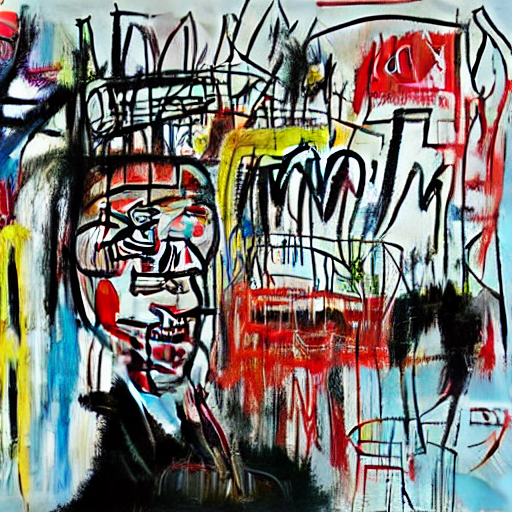

In [22]:
pipeline_output.images[0]

In [23]:
pipeline_output = pipeline(
    prompt = ['peoples in train like Basquiat'],
    num_inference_steps=20,
    cross_attention_kwargs={'scale':lora_scale},
    generator = torch.manual_seed(42)
)

  0%|          | 0/20 [00:00<?, ?it/s]

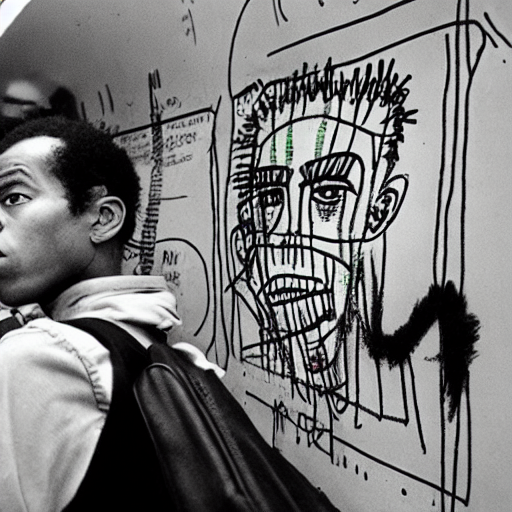

In [24]:
pipeline_output.images[0]

In [25]:
pipeline_output = pipeline(
    prompt = ['people draw painting like Basquiat'],
    num_inference_steps=20,
    cross_attention_kwargs={'scale':lora_scale},
    generator = torch.manual_seed(42)
)

  0%|          | 0/20 [00:00<?, ?it/s]

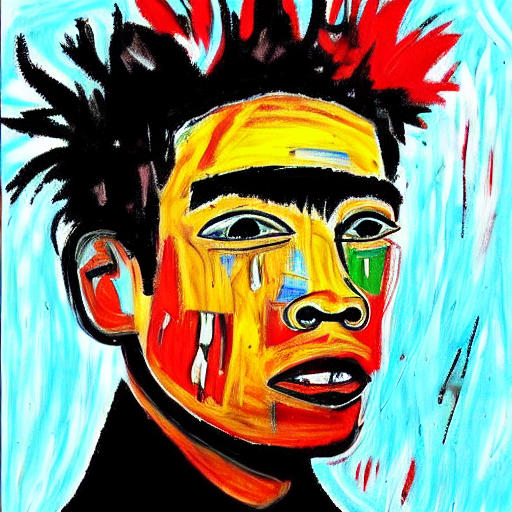

In [26]:
pipeline_output.images[0]

In [27]:
pipeline.save_pretrained('./basquiat_finetuning_save')